<a href="https://colab.research.google.com/github/alisharifi2000/LumiereNet/blob/main/Lumi%C3%A8reNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Primary  :
#----------------------------------
# 1. openpose for pose estimation    done!
# 2. extract sound from video  done!
# 3. sound feature extractor (MFCC) done!
# 4. train vae autoencoder done !
#----------------------------------

# to do  :
#----------------------------------
# 1.make dataset of youtube file about 1 hour and save it to google drive  done!
# 2.read and sample frames from video done !
# 3.find pose in sample data and save them to google drive
# 4.use data to train VAE
#----------------------------------

# Secondary
#----------------------------------
# SeqPix2Pix
#----------------------------------


# challange:
#-----------------------------------
# 1. change layer in perceptual loss
#-----------------------------------

# question farsi input sound different from english input sound ?

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# OpenPose

In [ ]:
# '''
# pose estimation

# https://modelzoo.co/model/convolutional-pose-machines
# https://modelzoo.co/model/openpose
# https://github.com/YangZeyu95/unofficial-implement-of-openpose

# '''

In [ ]:
## Install OpenPose

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

Selecting previously unselected package libgflags2.2.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [ ]:
# test openpose
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'RXABo9hm8B8'
YouTubeVideo(YOUTUBE_ID)
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID


[youtube] lfYyoVa20mU: Downloading webpage
ERROR: unable to open for writing: [Errno 95] Operation not supported: 'youtube.webm.part'


In [ ]:
cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.mp4

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('video.mp4', width=960, height=720)

In [ ]:
# detect poses on the these 5 seconds
!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)

# make pose from video

In [ ]:
# detect poses on the input video of dataset
#!rm openpose.avi
!cd openpose && ./build/examples/openpose/openpose.bin --video "/gdrive/My Drive/DataSet_LumiereNet/input_video.mkv" --write_json "/gdrive/My Drive/DataSet_LumiereNet/json_files/" --display 0 --disable_blending --net_resolution "608x400" --scale_number 4 --scale_gap 0.25 --hand --hand_scale_number 6 --hand_scale_range 0.4 --face --number_people_max 1 --write_video "/gdrive/My Drive/DataSet_LumiereNet/openpose.avi"
#!cd openpose && ./build/examples/openpose/openpose.bin --video "/gdrive/My Drive/DataSet_LumiereNet/input_video.mkv" --write_json "/gdrive/My Drive/DataSet_LumiereNet/" --display 0 --disable_blending --number_people_max 1 --write_video "/gdrive/My Drive/DataSet_LumiereNet/openpose.avi"
#!cd openpose && ./build/examples/openpose/openpose.bin --video "/gdrive/My Drive/DataSet_LumiereNet/input_video.mkv" --write_json "/gdrive/My Drive/DataSet_LumiereNet/json_files/" --display 0 --disable_blending --write_video "/gdrive/My Drive/DataSet_LumiereNet/openpose.avi"
# convert the result into MP4
!ffmpeg -y -loglevel info -i "/gdrive/My Drive/DataSet_LumiereNet/openpose.avi" "/gdrive/My Drive/DataSet_LumiereNet/openpose.mp4"

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
Empty frame detected, frame number 35007 of 35009. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 35007 of 35009. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
Empty frame detected, frame number 35007 of 35009. In /content/openpose/src/openpose/producer/producer.cpp:checkFrameIntegrity():290
OpenPose demo successfully finished. Total time: 22804.236773 seconds.
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls 

# DensePose

In [ ]:
import os
from os.path import exists, join, basename, splitext

# install Anaconda Python 2.7 to control the dependencies
# see for more info: 
if not exists('anaconda2'):
  !wget -q https://repo.anaconda.com/archive/Anaconda2-2019.03-Linux-x86_64.sh
  !chmod +x Anaconda2-2019.03-Linux-x86_64.sh
  !bash ./Anaconda2-2019.03-Linux-x86_64.sh -b -f -p /content/anaconda2
  # set PATH environment variable
  os.environ['PATH'] = "/content/anaconda2/bin:" + os.environ['PATH']
  # install PyTorch
  !conda install -y pyyaml=3.12
  !conda install -y mkl-include
  !conda install -y pytorch=1.0.1 torchvision cudatoolkit=10.0 -c pytorch
  !ln -s /content/anaconda2/lib/python2.7/site-packages/torch/lib/ /content/anaconda2/lib/python2.7/site-packages/
  # install GCC 4.9
  !conda install -y -c serge-sans-paille gcc_49
  !ln -fs /content/anaconda2/lib/libmpfr.so /content/anaconda2/lib/libmpfr.so.4
  os.environ['CC'] = '/content/anaconda2/bin/gcc-4.9'
  os.environ['CXX'] = '/content/anaconda2/bin/g++-4.9'
  # protobuf 3.5
  #!apt-get -qq remove -y protobuf-compiler
  !conda install -y protobuf=3.5
  # pycocotools
  !conda install -y -c conda-forge pycocotools
  # some missing dependencies
  !pip install opencv-python==4.0.0.21 memory_profiler
  
# we need some headers from the pytorch source
if not exists('pytorch'):
  !git clone -q --depth 1 --recursive -b v1.0.1 https://github.com/pytorch/pytorch

PREFIX=/content/anaconda2
installing: python-2.7.16-h9bab390_0 ...
using -f (force) option
Python 2.7.16 :: Anaconda, Inc.
installing: conda-env-2.6.0-1 ...
using -f (force) option
installing: blas-1.0-mkl ...
using -f (force) option
installing: ca-certificates-2019.1.23-0 ...
using -f (force) option
installing: intel-openmp-2019.3-199 ...
using -f (force) option
installing: libgcc-ng-8.2.0-hdf63c60_1 ...
using -f (force) option
installing: libgfortran-ng-7.3.0-hdf63c60_0 ...
using -f (force) option
installing: libstdcxx-ng-8.2.0-hdf63c60_1 ...
using -f (force) option
installing: bzip2-1.0.6-h14c3975_5 ...
using -f (force) option
installing: expat-2.2.6-he6710b0_0 ...
using -f (force) option
installing: fribidi-1.0.5-h7b6447c_0 ...
using -f (force) option
installing: gmp-6.1.2-h6c8ec71_1 ...
using -f (force) option
installing: graphite2-1.3.13-h23475e2_0 ...
using -f (force) option
installing: icu-58.2-h9c2bf20_1 ...
using -f (force) option
installing: jbig-2.1-hdba287a_0 ...
using -f 

In [ ]:
# some sanity checks
!conda --version
!protoc --version
!gcc-4.9 --version

conda 4.8.4
libprotoc 3.5.1
gcc-4.9 (GCC) 4.9.1
Copyright (C) 2014 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/facebookresearch/DensePose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone project
  !git clone -q --depth 1 $git_repo_url
  # install dependencies
  !cd $project_name && pip install -q -r requirements.txt
  # update CMakeLists.txt
  cmakelists_txt_content = """
cmake_minimum_required(VERSION 2.8.12 FATAL_ERROR)
set(Caffe2_DIR "/content/anaconda2/lib/python2.7/site-packages/torch/share/cmake/Caffe2/")
find_package(Caffe2 REQUIRED)

include_directories("/content/anaconda2/lib/python2.7/site-packages/torch/lib/include")
include_directories("/content/anaconda2/include")
include_directories("/content/pytorch")

add_library(libprotobuf STATIC IMPORTED)
set(PROTOBUF_LIB "/content/anaconda2/lib/libprotobuf.a")
set_property(TARGET libprotobuf PROPERTY IMPORTED_LOCATION "${PROTOBUF_LIB}")

if (${CAFFE2_VERSION} VERSION_LESS 0.8.2)
  # Pre-0.8.2 caffe2 does not have proper interface libraries set up, so we
  # will rely on the old path.
  message(WARNING
      "You are using an older version of Caffe2 (version " ${CAFFE2_VERSION}
      "). Please consider moving to a newer version.")
  include(cmake/legacy/legacymake.cmake)
  return()
endif()

# Add compiler flags.
set(CMAKE_C_FLAGS "${CMAKE_C_FLAGS} -std=c11")
set(CMAKE_CXX_FLAGS "${CMAKE_CXX_FLAGS} -std=c++11 -O2 -fPIC -Wno-narrowing")

# Print configuration summary.
include(cmake/Summary.cmake)
detectron_print_config_summary()

# Collect custom ops sources.
file(GLOB CUSTOM_OPS_CPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cc)
file(GLOB CUSTOM_OPS_GPU_SRCS ${CMAKE_CURRENT_SOURCE_DIR}/detectron/ops/*.cu)

# Install custom CPU ops lib.
add_library(
     caffe2_detectron_custom_ops SHARED
     ${CUSTOM_OPS_CPU_SRCS})

target_link_libraries(caffe2_detectron_custom_ops caffe2_library libprotobuf)
install(TARGETS caffe2_detectron_custom_ops DESTINATION lib)

# Install custom GPU ops lib, if gpu is present.
if (CAFFE2_USE_CUDA OR CAFFE2_FOUND_CUDA)
  # Additional -I prefix is required for CMake versions before commit (< 3.7):
  # https://github.com/Kitware/CMake/commit/7ded655f7ba82ea72a82d0555449f2df5ef38594
  list(APPEND CUDA_INCLUDE_DIRS -I${CAFFE2_INCLUDE_DIRS})
  CUDA_ADD_LIBRARY(
      caffe2_detectron_custom_ops_gpu SHARED
      ${CUSTOM_OPS_CPU_SRCS}
      ${CUSTOM_OPS_GPU_SRCS})

  target_link_libraries(caffe2_detectron_custom_ops_gpu caffe2_gpu_library libprotobuf)
  install(TARGETS caffe2_detectron_custom_ops_gpu DESTINATION lib)
endif()"""
  open(join(project_name, 'CMakeLists.txt'), 'w').write(cmakelists_txt_content)
  # build
  !cd $project_name && make
  !cd $project_name && make ops
  # download dense pose data
  !cd $project_name/DensePoseData && bash get_densepose_uv.sh

python2 setup.py develop --user
Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/content/anaconda2/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/DensePose/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/content/anaconda2/lib/python2.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/DensePose/detectron/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running develop
running egg_info
creating Detectron.egg-info
writing Detectron.egg-info/PKG-INFO
writing top-level names to Detectron.egg-inf

In [ ]:
!python2 $project_name/detectron/tests/test_spatial_narrow_as_op.py
!python2 $project_name/detectron/tests/test_zero_even_op.py

No handlers could be found for logger "caffe2.python.net_drawer"
net_drawer will not run correctly. Please install the correct dependencies.
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
Found Detectron ops lib: /content/anaconda2/lib/python2.7/site-packages/lib/libcaffe2_detectron_ops_gpu.so
...
----------------------------------------------------------------------
Ran 3 tests in 3.795s

OK
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it.

In [ ]:
import glob
paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/Frames/*.jpg')
len(paths)

7037

In [ ]:
for path in paths:
    !cd $project_name && python2 tools/infer_simple.py \
    --cfg configs/DensePose_ResNet101_FPN_s1x-e2e.yaml \
    --output-dir '/gdrive/My Drive/DataSet LumiereNet/DensePose/' \
    --image-ext jpg \
    --wts https://dl.fbaipublicfiles.com/densepose/DensePose_ResNet101_FPN_s1x-e2e.pkl \
    path

Streaming output truncated to the last 5000 lines.
[I net_dag_utils.cc:102] Operator graph pruning prior to chain compute took: 6.195e-06 secs
INFO infer_simple.py: 103: Processing path -> /gdrive/My Drive/DataSet LumiereNet/DensePose/path.pdf
Traceback (most recent call last):
  File "tools/infer_simple.py", line 140, in <module>
    main(args)
  File "tools/infer_simple.py", line 109, in main
    model, im, None, timers=timers
  File "/content/DensePose/detectron/core/test.py", line 58, in im_detect_all
    model, im, cfg.TEST.SCALE, cfg.TEST.MAX_SIZE, boxes=box_proposals
  File "/content/DensePose/detectron/core/test.py", line 137, in im_detect_bbox
    inputs, im_scale = _get_blobs(im, boxes, target_scale, target_max_size)
  File "/content/DensePose/detectron/core/test.py", line 1028, in _get_blobs
    blob_utils.get_image_blob(im, target_scale, target_max_size)
  File "/content/DensePose/detectron/utils/blob.py", line 44, in get_image_blob
    im, cfg.PIXEL_MEANS, target_scale, ta

# download video from youtube

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
DensePose

Mounted at /gdrive


In [ ]:
! ls '/gdrive/My Drive/DataSet LumiereNet'

ls: cannot access '/gdrive/My Drive/DataSet LumiereNet': No such file or directory


In [ ]:
!pip install youtube_dl

import youtube_dl

link = 'https://www.youtube.com/watch?v=d0yGdNEWdn0'

ydl_opts = {}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(link, download=False)
    video_title = info_dict.get('title', None)

path = f'/gdrive/My Drive/DataSet_LumiereNet/{video_title}.mp4'

ydl_opts.update({'outtmpl':path , 
                'f':'bestvideo[ext=mp4]+bestaudio[ext=m4a]/bestvideo+bestaudio'})

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([link])

! mv 'How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.mkv' 'input_video.mkv'

[youtube] d0yGdNEWdn0: Downloading webpage
[youtube] d0yGdNEWdn0: Downloading webpage


[download] Destination: /gdrive/My Drive/DataSet_LumiereNet/How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.f248
[download] 100% of 101.82MiB in 00:02
[download] Destination: /gdrive/My Drive/DataSet_LumiereNet/How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.f140
[download] 100% of 16.76MiB in 00:00
[ffmpeg] Merging formats into "/gdrive/My Drive/DataSet_LumiereNet/How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.mkv"
Deleting original file /gdrive/My Drive/DataSet_LumiereNet/How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.f248 (pass -k to keep)
Deleting original file /gdrive/My Drive/DataSet_LumiereNet/How to learn any language in six months | Chris Lonsdale | TEDxLingnanUniversity.mp4.f140 (pass -k to keep)


# make frame by frame video

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# import cv2
# import random

# # Opens the Video file
# cap= cv2.VideoCapture("/gdrive/MyDrive/DataSet_LumiereNet/openpose.mp4")
# i=0
# while(cap.isOpened()):
#     ret, frame = cap.read()
#     if ret == False:
#         break
#     f = random.randint(0, 5)
#     if i % 5 == f: 
#         cv2.imwrite('/gdrive/MyDrive/DataSet_LumiereNet/OpenPose Frames/frame'+str(int(i))+'.jpg',frame)
#     i+=1

# cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
vid = "/gdrive/MyDrive/DataSet_LumiereNet/openpose.mp4"
count=1
vidcap = cv2.VideoCapture(vid)

def getFrame(sec,i):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
         cv2.imwrite('/gdrive/MyDrive/DataSet_LumiereNet/OpenPose Frames/frame'+str(int(i))+'.jpg',image)
    return hasFrames

sec = 0
frameRate = 0.25 # Change this number to 1 for each 1 second
    
success = getFrame(sec,count)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec,count)

# SOUND
## get video of film

In [1]:
!pip install librosa
!pip install moviepy
!pip install pydub

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g46zvOLDv2OCy1CDbsRfD0dKrWEtmYz_BN8FGWDi7qEBHfCFzcbWLs
Mounted at /gdrive


In [ ]:
from moviepy.editor import *
audioclip = AudioFileClip("/gdrive/MyDrive/DataSet_LumiereNet/input_video.mkv")

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3555328/45929032 bytes (7.7%)7397376/45929032 bytes (16.1%)11567104/45929032 bytes (25.2%)15491072/45929032 bytes (33.7%)19595264/45929032 bytes (42.7%)23691264/45929032 bytes (51.6%)27910144/45929032 bytes (60.8%)32063488/45929032 bytes (69.8%)36331520/45929032 bytes (79.1%)40411136/45929032 bytes (88.0%)44441600/45929032 bytes (96.8%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

OSError: ignored

In [ ]:
audioclip.write_audiofile("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav")

## Split sounds to 1 secends files

In [ ]:
# from pydub import AudioSegment
# from pydub.utils import make_chunks

# myaudio = AudioSegment.from_file("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav" , "wav") 
# chunk_length_ms = 1000 # pydub calculates in millisec
# chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of one sec

# #Export all of the individual chunks as wav files

# for i, chunk in enumerate(chunks):
#     chunk_name = "/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound{}.wav".format(i)
#     if i%400 == 0:
#         print ("exporting", chunk_name)
#     chunk.export(chunk_name, format="wav")

exporting /gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound0.wav
exporting /gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound400.wav
exporting /gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound800.wav


In [ ]:
from pydub import AudioSegment
Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav")

end = len(Audio)
i = 0 
t1 = 0  #milliseconds
t2 = 1000 #milliseconds 

while(True):
    if t2 > end :
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav")
        newAudio = Audio[t1:]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound{}.wav".format(i), format="wav")
        break

    elif t2 < end:
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav")
        newAudio = Audio[t1:t2]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound{}.wav".format(i), format="wav")
        if i % 100 == 0:
            print('i : {} , t1 : {} , t2 : {}'.format(i,t1,t2))

    elif t2 == end:
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav")
        newAudio = Audio[t1:t2]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound{}.wav".format(i), format="wav")
        break

    t1 = t1 + 250
    t2 = t2 + 250
    i = i + 1

i : 0 , t1 : 0 , t2 : 1000
i : 100 , t1 : 25000 , t2 : 26000
i : 200 , t1 : 50000 , t2 : 51000
i : 300 , t1 : 75000 , t2 : 76000
i : 400 , t1 : 100000 , t2 : 101000
i : 500 , t1 : 125000 , t2 : 126000
i : 600 , t1 : 150000 , t2 : 151000
i : 700 , t1 : 175000 , t2 : 176000
i : 800 , t1 : 200000 , t2 : 201000
i : 900 , t1 : 225000 , t2 : 226000
i : 1000 , t1 : 250000 , t2 : 251000
i : 1100 , t1 : 275000 , t2 : 276000
i : 1200 , t1 : 300000 , t2 : 301000
i : 1300 , t1 : 325000 , t2 : 326000
i : 1400 , t1 : 350000 , t2 : 351000
i : 1500 , t1 : 375000 , t2 : 376000
i : 1600 , t1 : 400000 , t2 : 401000
i : 1700 , t1 : 425000 , t2 : 426000
i : 1800 , t1 : 450000 , t2 : 451000
i : 1900 , t1 : 475000 , t2 : 476000
i : 2000 , t1 : 500000 , t2 : 501000
i : 2100 , t1 : 525000 , t2 : 526000
i : 2200 , t1 : 550000 , t2 : 551000
i : 2300 , t1 : 575000 , t2 : 576000
i : 2400 , t1 : 600000 , t2 : 601000
i : 2500 , t1 : 625000 , t2 : 626000
i : 2600 , t1 : 650000 , t2 : 651000
i : 2700 , t1 : 675000 , t

In [ ]:
# from pydub import AudioSegment
# from pydub.silence import split_on_silence

# sound_file = AudioSegment.from_file("/gdrive/MyDrive/DataSet_LumiereNet/sound.wav" , "wav") 
# audio_chunks = split_on_silence(sound_file, 
#     # must be silent for at least 0.1 a second
#     min_silence_len=100,

#     # consider it silent if quieter than -16 dBFS
#     #silence_thresh=-16
# )

# for i, chunk in enumerate(audio_chunks):
#     chunk_name = "/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound{}.wav".format(i)
#     if i%400 == 0:
#         print ("exporting", chunk_name)
#     chunk.export(chunk_name, format="wav")

## MFCC **1024**

In [ ]:
import glob
paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/*.wav')
print(len(paths))

4670


In [ ]:
paths[100]

'/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound277.wav'

In [ ]:
import librosa
import IPython.display as ipd #so that we can listen at the audio
audio, sr = librosa.load(paths[100])
ipd.Audio(audio, rate = sr)

In [3]:
import librosa
def extract_mfcc(path):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path sound
    #Output: mfcc_features'''
    y, sr = librosa.load(path)
    #mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr,n_mfcc=1024).T,axis=0)
    mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=1024)
    return mfccs

In [ ]:
print(extract_mfcc(paths[300]).shape)
print(extract_mfcc(paths[150]).shape)
print(extract_mfcc(paths[7]).shape)
print(extract_mfcc(paths[1103]).shape)

(128, 44)
(128, 44)
(128, 44)
(128, 44)


# Code

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Bidirectional ,LSTM , Input , Conv2D  ,MaxPooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

# VAE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [7]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_layer1 (Conv2D)         (None, 254, 254, 16) 448         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_layer2 (MaxPooling2D)   (None, 127, 127, 16) 0           encoder_layer1[0][0]             
__________________________________________________________________________________________________
encoder_layer3 (Conv2D)         (None, 125, 125, 32) 4640        encoder_layer2[0][0]             
____________________________________________________________________________________________

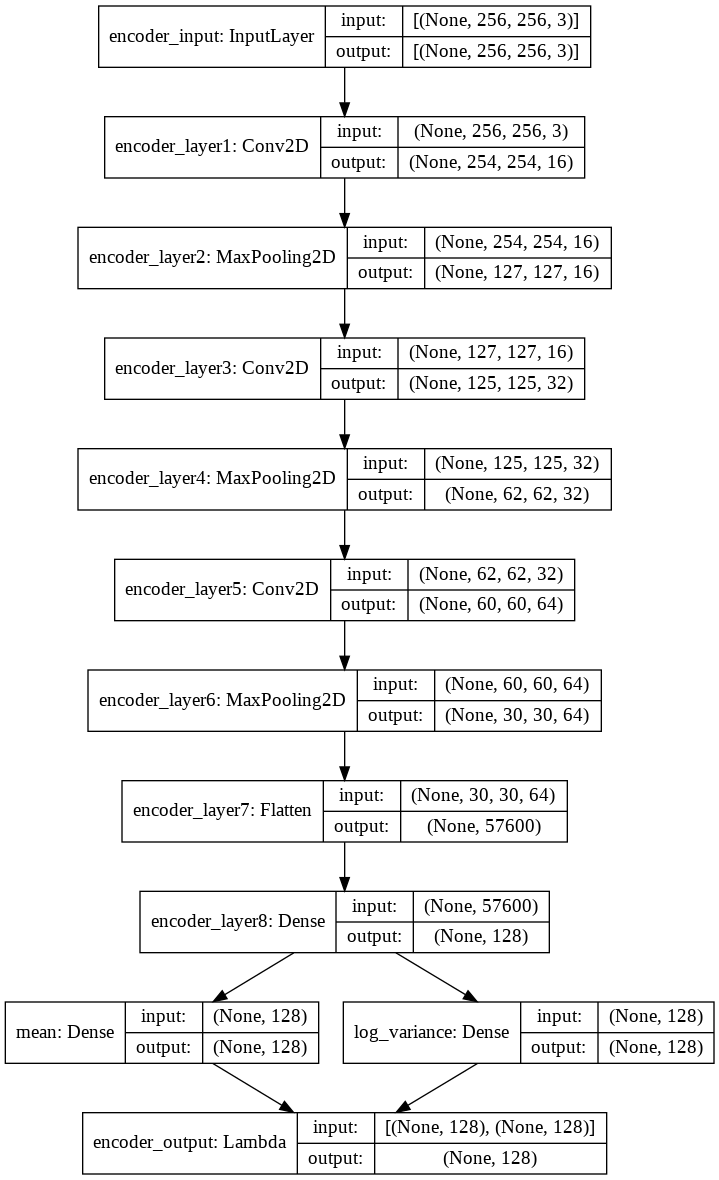

In [8]:
# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer2')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
encoder = Conv2D(64,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer6')(encoder)
encoder = Flatten(name = 'encoder_layer7')(encoder)
encoder = Dense(128 , activation = 'relu', name = 'encoder_layer8')(encoder)

distribution_mean = Dense(128, name='mean')(encoder)
distribution_variance = Dense(128, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')
print(Encoder.summary())
plot_model(Encoder, show_shapes=True)

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 128)]             0         
_________________________________________________________________
decoder_layer1 (Reshape)     (None, 1, 1, 128)         0         
_________________________________________________________________
decoder_layer2 (Conv2DTransp (None, 3, 3, 64)          73792     
_________________________________________________________________
decoder_layer3 (UpSampling2D (None, 48, 48, 64)        0         
_________________________________________________________________
decoder_layer4 (Conv2DTransp (None, 50, 50, 64)        36928     
_________________________________________________________________
decoder_layer5 (UpSampling2D (None, 400, 400, 64)      0         
_________________________________________________________________
decoder_layer6 (Conv2DTransp (None, 402, 402, 64)      3692

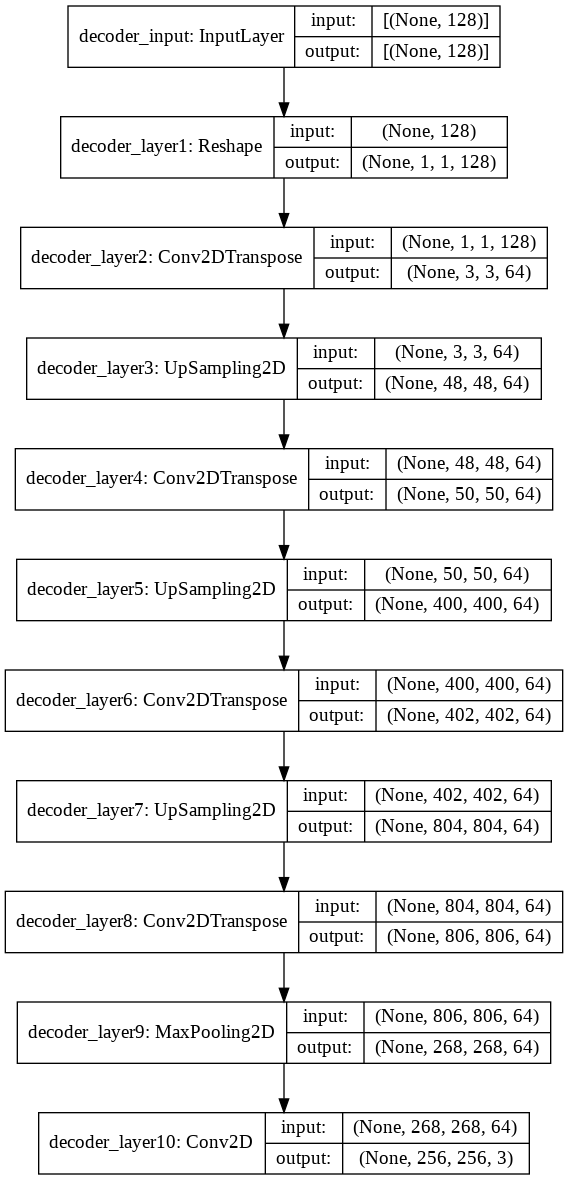

In [9]:
#VAE decoder

'''
input shape = (256,256,3)
'''

input_shape = 128

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 128),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = MaxPooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')
print(Decoder.summary())
plot_model(Decoder, show_shapes=True)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 128)               7429536   
_________________________________________________________________
Decoder (Functional)         (None, 256, 256, 3)       217027    
Total params: 7,646,563
Trainable params: 7,646,563
Non-trainable params: 0
_________________________________________________________________
None


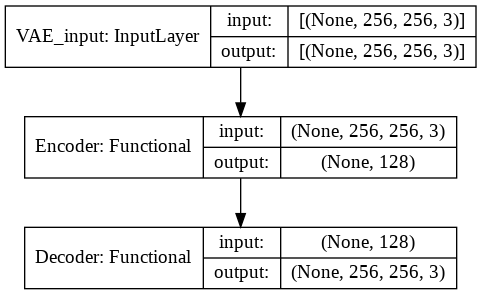

In [ ]:
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

print(VAE.summary())
plot_model(VAE, show_shapes=True)

In [ ]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv1","block3_conv3" ,'block4_conv1',
                   'block4_conv3','block5_conv1','block5_conv2','block5_conv3','block5_conv4']

selected_layer_weights = [1.0, 1.0 , 1.0 , 2.0 ,2.0,
                         4.0 , 4.0 ,8.0 ,8.0, 16.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0

    img = K.batch_flatten(input_image)
    r_img = K.batch_flatten(reconstruct_image)
    r_error =  K.sum(K.abs(img - r_img), axis=-1) 

    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):

        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.abs(h1 - h2), axis=-1)

    rc_loss = (rc_loss / (sum(selected_layer_weights)))
    error = (rc_loss + r_error)/2

    return error 

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
#rmsprop = RMSprop(learning_rate=0.0000025)
rmsprop = RMSprop(learning_rate=0.0000001)
VAE.compile(loss= perceptual_loss, optimizer= rmsprop)

In [ ]:
import glob
paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/OpenPose Frames/*jpg')
print(len(paths))

4668


In [ ]:
# import tensorflow as tf
# train_dir = '/gdrive/MyDrive/DataSet_LumiereNet/OpenPose Frames/'
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255)
# train_generator = train_datagen.flow_from_directory(train_dir,
#                                                     target_size=(256, 256), 
#                                                     color_mode='rgb',
#                                                     class_mode='input',
#                                                     batch_size=64)

In [ ]:
import tensorflow as tf

images = []
for path in paths :
    img = load_img(path,target_size=(256,256))
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    images.append(img)
images = np.asarray(images)

In [ ]:
import pickle

data = {'images': images}
p  = '/gdrive/MyDrive/DataSet_LumiereNet/OpenPoseFrames.pickle'
outfile = open(p,'wb')
pickle.dump(data,outfile)
outfile.close()

In [ ]:
print(images.shape)

(4668, 256, 256, 3)


In [ ]:
es = EarlyStopping(monitor="val_loss",
                   patience=15)

rs = ReduceLROnPlateau(monitor="val_loss",
                  factor=0.1,
                  patience=4,
                  verbose=1,
                  mode="auto")

In [ ]:
VAE.fit(x=images,y=images,
    epochs=50,
    verbose = 1,
    batch_size = 8,
    validation_split = 0.25,
    callbacks = [es,rs])

Epoch 1/50
438/438 [==============================] - 490s 1s/step - loss: 132476.7542 - val_loss: 119617.0312
Epoch 2/50
438/438 [==============================] - 467s 1s/step - loss: 114668.5510 - val_loss: 102325.9688
Epoch 3/50
438/438 [==============================] - 465s 1s/step - loss: 99316.2413 - val_loss: 89967.1094
Epoch 4/50
438/438 [==============================] - 460s 1s/step - loss: 89016.1637 - val_loss: 83494.2812
Epoch 5/50
438/438 [==============================] - 457s 1s/step - loss: 84261.0875 - val_loss: 80945.6016
Epoch 6/50
438/438 [==============================] - 455s 1s/step - loss: 82316.6527 - val_loss: 80177.6953
Epoch 7/50
438/438 [==============================] - 454s 1s/step - loss: 81898.5257 - val_loss: 79949.8125
Epoch 8/50
438/438 [==============================] - 453s 1s/step - loss: 81822.9767 - val_loss: 79902.5234
Epoch 9/50
438/438 [==============================] - 453s 1s/step - loss: 81808.0045 - val_loss: 79887.6016
Epoch 10/50
438

In [ ]:
VAE.save_weights('/gdrive/MyDrive/DataSet_LumiereNet/VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/DataSet_LumiereNet/Encoder_weights.h5')
Decoder.save_weights('/gdrive/MyDrive/DataSet_LumiereNet/Decoder_weights.h5')

# BLSTM

Model: "BLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BLSTM_input (InputLayer)     [(None, 128, 44)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               616448    
_________________________________________________________________
BLSTM_output (Dense)         (None, 128)               65664     
Total params: 682,112
Trainable params: 682,112
Non-trainable params: 0
_________________________________________________________________
None


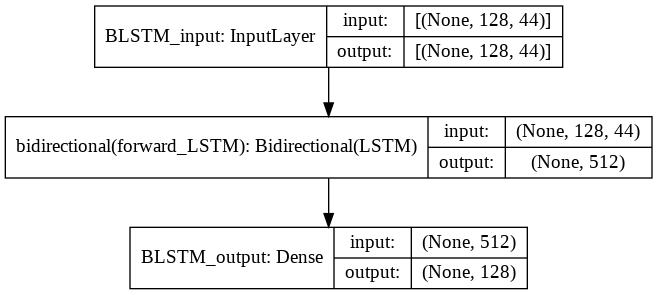

In [10]:
#BLSTM model
'''
learning rate = 0.000001
window size = 44
'''

input_shape = (128,44)
input_model = Input(input_shape,name = 'BLSTM_input')
forward_LSTM = Bidirectional(LSTM(256,activation='relu',  name = 'forward_LSTM'))(input_model)
#forward_LSTM = Bidirectional(LSTM(256, return_sequences=True ,  name = 'forward_LSTM'))(input_model)
#backward_LSTM = Bidirectional(LSTM(256,activation='relu' , name = 'backward_LSTM'))(forward_LSTM)
output_model = Dense(128 , name = 'BLSTM_output')(forward_LSTM)

BLSTM = Model(inputs= [input_model], outputs=[output_model],name = 'BLSTM')

print(BLSTM.summary())
plot_model(BLSTM, show_shapes=True)

#Sound2Pose

In [11]:
Decoder.load_weights('/gdrive/MyDrive/DataSet_LumiereNet/Decoder_weights.h5')

In [12]:
for layer in Decoder.layers:
    layer.trainable = False

In [13]:
print(Decoder.summary())

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 128)]             0         
_________________________________________________________________
decoder_layer1 (Reshape)     (None, 1, 1, 128)         0         
_________________________________________________________________
decoder_layer2 (Conv2DTransp (None, 3, 3, 64)          73792     
_________________________________________________________________
decoder_layer3 (UpSampling2D (None, 48, 48, 64)        0         
_________________________________________________________________
decoder_layer4 (Conv2DTransp (None, 50, 50, 64)        36928     
_________________________________________________________________
decoder_layer5 (UpSampling2D (None, 400, 400, 64)      0         
_________________________________________________________________
decoder_layer6 (Conv2DTransp (None, 402, 402, 64)      3692

Model: "Sound2Pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sound_input (InputLayer)     [(None, 128, 44)]         0         
_________________________________________________________________
BLSTM (Functional)           (None, 128)               682112    
_________________________________________________________________
Decoder (Functional)         (None, 256, 256, 3)       217027    
Total params: 899,139
Trainable params: 682,112
Non-trainable params: 217,027
_________________________________________________________________
None


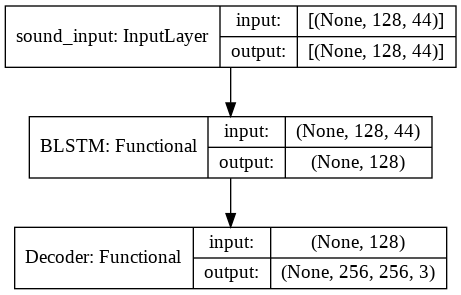

In [14]:
input_shape = (128,44)
input_sound = Input(input_shape,name = 'sound_input')
latent = BLSTM(input_sound)
image_output = Decoder(latent)

sound2pose = Model(inputs= [input_sound], outputs=[image_output],name = 'Sound2Pose')


rmsprop = RMSprop(learning_rate=0.000001)
#rmsprop = RMSprop(learning_rate=0.0001)
sound2pose.compile(loss='mse', optimizer= rmsprop)

print(sound2pose.summary())
plot_model(sound2pose, show_shapes=True)

In [15]:
import glob
images_paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/OpenPose Frames/*.jpg')
print(len(images_paths))

4668


In [16]:
import glob
sounds_paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/*.wav')
print(len(sounds_paths))

4670


In [17]:
for i in range(0,(len(sounds_paths) - len(images_paths))):
    images_paths.append(images_paths[-1])

In [18]:
print(len(images_paths))
print(len(sounds_paths))
print(len(images_paths)/len(sounds_paths))

4670
4670
1.0


In [19]:
#make dataset 
x = []
y = []

for i,sounds in enumerate(sounds_paths):
    if i%100 == 0:
        print('{} from {}'.format(i,len(sounds_paths)))
    sound_features = extract_mfcc(sounds)
    if sound_features.shape == (128,44):
        x.append(sound_features)
        img = load_img(images_paths[i],target_size=(256,256))
        img = img_to_array(img)
        img = img.astype(np.float32)
        img = img/255.0
        y.append(img)
    else:
        print(sounds)

x = np.asarray(x)
y = np.asarray(y)

0 from 4670
100 from 4670
200 from 4670
300 from 4670
400 from 4670
500 from 4670
600 from 4670
700 from 4670
800 from 4670
900 from 4670
/gdrive/MyDrive/DataSet_LumiereNet/sound_frame/sound4669.wav
1000 from 4670
1100 from 4670
1200 from 4670
1300 from 4670
1400 from 4670
1500 from 4670
1600 from 4670
1700 from 4670
1800 from 4670
1900 from 4670
2000 from 4670
2100 from 4670
2200 from 4670
2300 from 4670
2400 from 4670
2500 from 4670
2600 from 4670
2700 from 4670
2800 from 4670
2900 from 4670
3000 from 4670
3100 from 4670
3200 from 4670
3300 from 4670
3400 from 4670
3500 from 4670
3600 from 4670
3700 from 4670
3800 from 4670
3900 from 4670
4000 from 4670
4100 from 4670
4200 from 4670
4300 from 4670
4400 from 4670
4500 from 4670
4600 from 4670


In [20]:
x.shape

(4669, 128, 44)

In [21]:
y.shape

(4669, 256, 256, 3)

In [22]:
es = EarlyStopping(monitor="val_loss",
                   patience=35)

rs = ReduceLROnPlateau(monitor="val_loss",
                  factor=0.1,
                  patience=6,
                  verbose=1,
                  mode="auto")

In [23]:
sound2pose.fit(x=x,y=y,
        epochs=60,
        shuffle = False,
        verbose = 1,
        batch_size = 8,
        validation_split = 0.25,
        callbacks = [es,rs])

sound2pose.save_weights('/gdrive/MyDrive/DataSet_LumiereNet/sound2pose_weights.h5')

Epoch 1/150
438/438 [==============================] - 322s 712ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 2/150
438/438 [==============================] - 307s 700ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 3/150
438/438 [==============================] - 309s 707ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 4/150
438/438 [==============================] - 308s 703ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 5/150
438/438 [==============================] - 306s 699ms/step - loss: 0.0071 - val_loss: 0.0062

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 6/150
438/438 [==============================] - 306s 699ms/step - loss: 0.0071 - val_loss: 0.0064
Epoch 7/150
438/438 [==============================] - 307s 701ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 8/150
438/438 [==============================] - 306s 699ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 9/150
438/438 [==============================] - 306s 699ms/step - loss: 

In [24]:
sound2pose.save_weights('/gdrive/MyDrive/DataSet_LumiereNet/sound2pose_weights.h5')

# testing

In [25]:
!pip install librosa
!pip install moviepy
!pip install pydub

In [26]:
import librosa
def extract_mfcc(path):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path sound
    #Output: mfcc_features'''
    y, sr = librosa.load(path)
    #mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr,n_mfcc=1024).T,axis=0)
    mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=1024)
    return mfccs

In [27]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Bidirectional ,LSTM , Input , Conv2D  ,MaxPooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

In [ ]:
#VAE decoder

'''
input shape = (256,256,3)
'''

input_shape = 128

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 128),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(64, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = MaxPooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')
print(Decoder.summary())
plot_model(Decoder, show_shapes=True)

In [ ]:
#BLSTM model
'''
learning rate = 0.000001
window size = 44
'''

input_shape = (128,44)
input_model = Input(input_shape,name = 'BLSTM_input')
forward_LSTM = Bidirectional(LSTM(256,activation='relu',  name = 'forward_LSTM'))(input_model)
#forward_LSTM = Bidirectional(LSTM(256, return_sequences=True ,  name = 'forward_LSTM'))(input_model)
#backward_LSTM = Bidirectional(LSTM(256,activation='relu' , name = 'backward_LSTM'))(forward_LSTM)
output_model = Dense(128 , name = 'BLSTM_output')(forward_LSTM)

BLSTM = Model(inputs= [input_model], outputs=[output_model],name = 'BLSTM')

print(BLSTM.summary())
plot_model(BLSTM, show_shapes=True)

In [ ]:
input_shape = (128,44)
input_sound = Input(input_shape,name = 'sound_input')
latent = BLSTM(input_sound)
image_output = Decoder(latent)

sound2pose = Model(inputs= [input_sound], outputs=[image_output],name = 'Sound2Pose')


rmsprop = RMSprop(learning_rate=0.000001)
#rmsprop = RMSprop(learning_rate=0.0001)
sound2pose.compile(loss='mse', optimizer= rmsprop)

print(sound2pose.summary())
plot_model(sound2pose, show_shapes=True)

In [28]:
sound2pose.load_weights('/gdrive/MyDrive/DataSet_LumiereNet/sound2pose_weights.h5')

In [ ]:
# !pip install youtube_dl

# import youtube_dl

# link = 'https://www.youtube.com/watch?v=ueMNqdB1QIE'

# ydl_opts = {}

# with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#     info_dict = ydl.extract_info(link, download=False)
#     video_title = info_dict.get('title', None)

# path = f'/gdrive/My Drive/DataSet_LumiereNet/{video_title}.mp4'

# ydl_opts.update({'outtmpl':path , 
#                 'f':'bestvideo[ext=mp4]+bestaudio[ext=m4a]/bestvideo+bestaudio'})

# with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#     ydl.download([link])

In [29]:
from pydub import AudioSegment
Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound_test.wav")

end = len(Audio)
i = 0 
t1 = 0  #milliseconds
t2 = 1000 #milliseconds 

while(True):
    if t2 > end :
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound_test.wav")
        newAudio = Audio[t1:]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame_test/sound{}.wav".format(i), format="wav")
        break

    elif t2 < end:
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound_test.wav")
        newAudio = Audio[t1:t2]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame_test/sound{}.wav".format(i), format="wav")
        if i % 100 == 0:
            print('i : {} , t1 : {} , t2 : {}'.format(i,t1,t2))

    elif t2 == end:
        Audio  = AudioSegment.from_wav("/gdrive/MyDrive/DataSet_LumiereNet/sound_test.wav")
        newAudio = Audio[t1:t2]
        newAudio.export("/gdrive/MyDrive/DataSet_LumiereNet/sound_frame_test/sound{}.wav".format(i), format="wav")
        break

    t1 = t1 + 250
    t2 = t2 + 250
    i = i + 1

i : 0 , t1 : 0 , t2 : 1000
i : 100 , t1 : 25000 , t2 : 26000
i : 200 , t1 : 50000 , t2 : 51000
i : 300 , t1 : 75000 , t2 : 76000
i : 400 , t1 : 100000 , t2 : 101000
i : 500 , t1 : 125000 , t2 : 126000
i : 600 , t1 : 150000 , t2 : 151000
i : 700 , t1 : 175000 , t2 : 176000
i : 800 , t1 : 200000 , t2 : 201000
i : 900 , t1 : 225000 , t2 : 226000
i : 1000 , t1 : 250000 , t2 : 251000
i : 1100 , t1 : 275000 , t2 : 276000
i : 1200 , t1 : 300000 , t2 : 301000
i : 1300 , t1 : 325000 , t2 : 326000
i : 1400 , t1 : 350000 , t2 : 351000
i : 1500 , t1 : 375000 , t2 : 376000
i : 1600 , t1 : 400000 , t2 : 401000
i : 1700 , t1 : 425000 , t2 : 426000
i : 1800 , t1 : 450000 , t2 : 451000
i : 1900 , t1 : 475000 , t2 : 476000
i : 2000 , t1 : 500000 , t2 : 501000
i : 2100 , t1 : 525000 , t2 : 526000
i : 2200 , t1 : 550000 , t2 : 551000
i : 2300 , t1 : 575000 , t2 : 576000
i : 2400 , t1 : 600000 , t2 : 601000
i : 2500 , t1 : 625000 , t2 : 626000
i : 2600 , t1 : 650000 , t2 : 651000
i : 2700 , t1 : 675000 , t

In [30]:
del x
del y

In [31]:
sounds_paths = glob.glob('/gdrive/MyDrive/DataSet_LumiereNet/sound_frame_test/*.wav')
print(len(sounds_paths))

3856


In [32]:
#make dataset 
x_test = []

for i,sounds in enumerate(sounds_paths):
    if i%100 == 0:
        print('{} from {}'.format(i,len(sounds_paths)))
    sound_features = extract_mfcc(sounds)
    if sound_features.shape == (128,44):
            x_test.append(sound_features)
    else:
        print(sounds)

x_test = np.asarray(x_test)

0 from 3856
100 from 3856
200 from 3856
300 from 3856
400 from 3856
500 from 3856
600 from 3856
700 from 3856
800 from 3856
900 from 3856
1000 from 3856
1100 from 3856
1200 from 3856
1300 from 3856
1400 from 3856
1500 from 3856
1600 from 3856
1700 from 3856
1800 from 3856
1900 from 3856
2000 from 3856
2100 from 3856
2200 from 3856
2300 from 3856
2400 from 3856
2500 from 3856
2600 from 3856
2700 from 3856
2800 from 3856
2900 from 3856
3000 from 3856
3100 from 3856
3200 from 3856
3300 from 3856
3400 from 3856
3500 from 3856
3600 from 3856
3700 from 3856
3800 from 3856
/gdrive/MyDrive/DataSet_LumiereNet/sound_frame_test/sound3855.wav


In [33]:
x_test.shape

(3855, 128, 44)

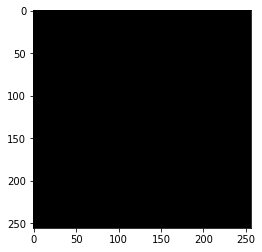

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 4489, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py", line 249, in wrapped
    error_in_function=error_in_function)


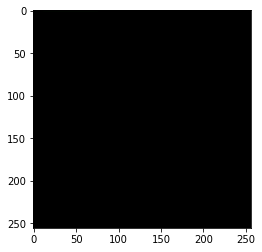

KeyboardInterrupt: ignored

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

%matplotlib inline

for i in range(x_test.shape[0]):
    pose = sound2pose(x_test[i].reshape(1,128,44))
    pose = (255.0 - pose[0]/255.0)
    pose = pose.numpy()
    if (pose == np.ones((256,256,3))).all() == False:
        plt.imshow(pose)
        plt.show()